# Z:P ratio regridded, check how this value ranges throughout the Arctic Ocean

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean
from cartopy.util import add_cyclic_point
from mpl_toolkits.basemap import Basemap

In [2]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result


In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [5]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [6]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [7]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [8]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

ds= xr.open_mfdataset(newNCDFfiles,combine='by_coords')

### Import regridded Zooplankton Carbon

In [9]:
zoo1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo1C.*.nc', recursive=True))
zoo1_ds = xr.open_mfdataset(zoo1_inds,combine='by_coords')
zoo2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo2C.*.nc', recursive=True))
zoo2_ds = xr.open_mfdataset(zoo2_inds,combine='by_coords')
zoo3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo3C.*.nc', recursive=True))
zoo3_ds = xr.open_mfdataset(zoo3_inds,combine='by_coords')
zoo4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo4C.*.nc', recursive=True))
zoo4_ds = xr.open_mfdataset(zoo4_inds,combine='by_coords')
zoo5_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo5C.*.nc', recursive=True))
zoo5_ds = xr.open_mfdataset(zoo5_inds,combine='by_coords')
zoo6_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/remapgrid_'+new_file+'_zoo6C.*.nc', recursive=True))
zoo6_ds = xr.open_mfdataset(zoo6_inds,combine='by_coords')

### Import regridded phytoplankton carbon

In [10]:
pp_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_ppC.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,combine='by_coords')
mp1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_mp1C.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,combine='by_coords')
mp2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_mp2C.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,combine='by_coords')
mp3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_mp3C.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,combine='by_coords')
mp4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_mp4C.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,combine='by_coords')
diat1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_diat1C.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,combine='by_coords')
diat2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_diat2C.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,combine='by_coords')
diat3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_diat3C.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,combine='by_coords')
diaz_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_diazC.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,combine='by_coords')

In [11]:
## Gaby's Path 
jluo_path = '/glade/u/home/jluo/cesm_scripts/size_structured/nl_input/cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
gabyn_path = '/glade/u/home/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+new_file+'/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')
sizes

,type,sname,mass_ugC,vol_um3,ESD_mm,Qp_fixed,mmolC
1,phyto,pp,9.266989e-08,3.706795e-01,0.000891,0.004651,7.715418e-12
2,phyto,mp1,8.241979e-06,1.805089e+01,0.003255,0.006824,6.862025e-10
0,phyto,diaz,5.499929e-05,1.227865e+02,0.006167,0.003333,4.579077e-09
3,phyto,mp2,8.888712e-05,8.790197e+02,0.011885,0.008656,7.400476e-09
6,phyto,diat1,5.004513e-04,1.327390e+04,0.029376,0.010289,4.166608e-08
9,zoo,zoo1,2.803686e-03,2.355042e+04,0.035563,0.008547,2.334265e-07
7,phyto,diat2,3.803133e-03,1.326626e+05,0.063278,0.012602,3.166375e-07
4,phyto,mp3,4.830334e-03,4.280541e+04,0.043401,0.012907,4.021592e-07
8,phyto,diat3,2.890156e-02,1.325863e+06,0.136301,0.015435,2.406258e-06
10,zoo,zoo2,8.933984e-02,7.447577e+05,0.112462,0.008547,7.438168e-06


In [12]:
grazing=pd.read_csv(nl_config+'grazing_input_data.csv')
grazing = grazing.dropna(subset=['sname1','sname2'])
grazing = grazing[['sname1', 'sname2', 'z_umax_0_per_day']]


# calculate sum of the z_umax values
# by prey
sum_z_umax_by_prey = pd.DataFrame(grazing.groupby(['sname1'])['z_umax_0_per_day'].sum())
sum_z_umax_by_prey = sum_z_umax_by_prey.rename(index=str, columns={'z_umax_0_per_day':'sum_z_umax_by_prey'})

# by pred
sum_z_umax_by_pred = pd.DataFrame(grazing.groupby(['sname2'])['z_umax_0_per_day'].sum())
sum_z_umax_by_pred = sum_z_umax_by_pred.rename(index=str, columns={'z_umax_0_per_day':'sum_z_umax_by_pred'})

# join and calculate a per-grazer percentage
grazing = grazing.set_index('sname1').join(sum_z_umax_by_prey)
grazing['z_umax_pct_by_prey'] = grazing.z_umax_0_per_day / grazing.sum_z_umax_by_prey
grazing = grazing.reset_index()

grazing = grazing.set_index('sname2').join(sum_z_umax_by_pred)
grazing['z_umax_pct_by_pred'] = grazing.z_umax_0_per_day / grazing.sum_z_umax_by_pred
grazing = grazing.reset_index()
grazing.head(5)

,sname2,sname1,z_umax_0_per_day,sum_z_umax_by_prey,z_umax_pct_by_prey,sum_z_umax_by_pred,z_umax_pct_by_pred
0,zoo1,diat1,0.147034,1.953287,0.075275,10.362452,0.014189
1,zoo1,diaz,3.424788,3.603350,0.950446,10.362452,0.330500
2,zoo1,mp1,3.059491,3.059491,1.000000,10.362452,0.295248
3,zoo1,mp2,1.836484,7.934161,0.231465,10.362452,0.177225
4,zoo1,pp,1.894655,1.894655,1.000000,10.362452,0.182839


### Zooplankton biomass

In [13]:
zooC_regrid = zoo1_ds.zoo1C+zoo2_ds.zoo2C+zoo3_ds.zoo3C+zoo4_ds.zoo4C+zoo5_ds.zoo5C+zoo6_ds.zoo6C #mmol/m^3
zooC_regrid = zooC_regrid.isel(z_t_150m=slice(None,10)).sum(dim='z_t_150m')* 10 #(mmolC $m^{-2}$)

### Phytoplankton biomass

In [14]:
phytoC_regrid = pp_ds.ppC+mp1_ds.mp1C+mp2_ds.mp2C+mp3_ds.mp3C+mp4_ds.mp4C+diaz_ds.diazC+diat1_ds.diat1C+diat2_ds.diat2C+diat3_ds.diat3C #mmol/m^3
phytoC_regrid = phytoC_regrid.isel(z_t_150m=slice(None,10)).sum(dim='z_t_150m')* 10 #(mmolC $m^{-2}$)

## Add threshold/mask to remove any biomass less than 1 mmol C m-2 (this might remove the low biomass in the Arctic Oceean under the ice and make it zero?

In [15]:
mask_less_than_zero = phytoC_regrid.values < 5 # find all that are less than zero 
new_bmss = phytoC_regrid.values
new_bmss[mask_less_than_zero] = np.nan # Make these values zero

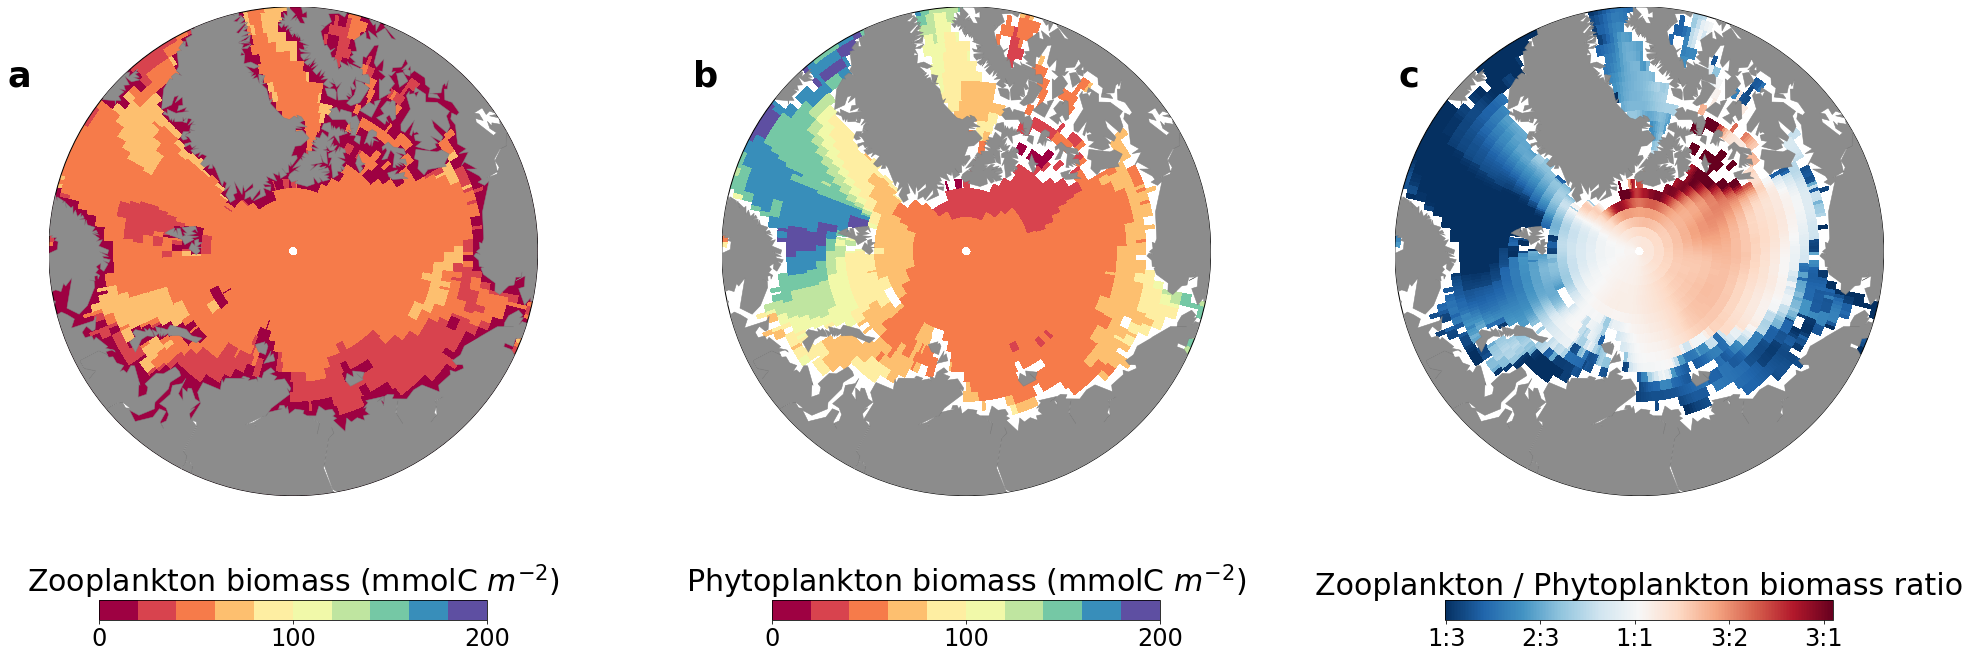

In [26]:
fig = plt.figure(figsize=(28, 10))

lat = pp_ds.lat
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
zoo, lon = add_cyclic_point(np.nanmean(zooC_regrid,axis=0), coord=pp_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,lat))
cf = m.pcolormesh(x,y,zoo,shading='flat',cmap=plt.cm.get_cmap('Spectral', 10),vmin = 0, vmax=200) 
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[0,100,200],shrink=0.75, orientation='horizontal')
cb.ax.set_xticklabels(['0','100','200'])
cb.ax.set_title('Zooplankton biomass (mmolC $m^{-2}$)', fontsize = 30)
cb.ax.tick_params(labelsize=24)


ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
phyto, lon = add_cyclic_point(np.nanmean(new_bmss,axis=0), coord=pp_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,lat))
cf = m.pcolormesh(x,y,phyto,shading='flat',cmap=plt.cm.get_cmap('Spectral', 10),vmin = 0, vmax=200)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[0,100,200],shrink=0.75, orientation='horizontal')
cb.ax.set_xticklabels(['0','100','200'])
cb.ax.set_title('Phytoplankton biomass (mmolC $m^{-2}$)', fontsize = 30)
cb.ax.tick_params(labelsize=24)


ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
zoo, lon = add_cyclic_point(np.nanmean(zooC_regrid,axis=0)/np.nanmean(new_bmss,axis=0), coord=pp_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,lat))
cf = m.pcolormesh(x,y,zoo,shading='flat',cmap='RdBu_r',vmin = 0.33, vmax=1.7)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[0.333,0.666,1,1.333,1.666],shrink=0.75, orientation='horizontal')
cb.ax.set_xticklabels(['1:3','2:3','1:1','3:2','3:1'])
cb.ax.set_title('Zooplankton / Phytoplankton biomass ratio', fontsize = 30)
cb.ax.tick_params(labelsize=24)
fig.text(0.01, 0.875, 'a',fontsize=35, fontweight='bold')
fig.text(0.35, 0.875, 'b',fontsize=35, fontweight='bold')
fig.text(0.7, 0.875, 'c',fontsize=35, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/AO/biomass_ZPratio_regrid_Arctic'+new_file+'.png',dpi=600, bbox_inches='tight')

## Import nutrient concentrations

In [17]:
no3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_NO3.*.nc', recursive=True))
no3_ds = xr.open_mfdataset(no3_inds,combine='by_coords')
po4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_PO4.*.nc', recursive=True))
po4_ds = xr.open_mfdataset(po4_inds,combine='by_coords')
sio3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_SiO3.*.nc', recursive=True))
sio3_ds = xr.open_mfdataset(sio3_inds,combine='by_coords')

In [18]:
ZP_ratio = np.nanmean(zooC_regrid,axis=0)/np.nanmean(phytoC_regrid,axis=0)
zooC = np.nanmean(zooC_regrid,axis=0)
phytoC = np.nanmean(new_bmss,axis=0)

In [19]:
zooC.shape

(180, 360)

### Check How different each region of the Arctic is in ZP, P, Z, and PO4 

In [20]:
ZP_ao = ZP_ratio[170:180,:]
ZP_cs = ZP_ratio[149:170,0:25]
ZP_bs = ZP_ratio[149:170,25:55]
ZP_ca = ZP_ratio[149:170,55:110]
ZP_bb = ZP_ratio[149:170,110:135]
ZP_ess = ZP_ratio[149:170,325:360]
ZP_ls = ZP_ratio[149:170,270:325]
ZP_ns = ZP_ratio[149:170,155:205]
ZP_bts =ZP_ratio[149:170,205:233]
ZP_ks = ZP_ratio[149:170,233:270]

In [21]:
P_ao = phytoC[170:180,:]
P_cs = phytoC[149:170,0:25]
P_bs = phytoC[149:170,25:55]
P_ca = phytoC[149:170,55:110]
P_bb = phytoC[149:170,110:135]
P_ess = phytoC[149:170,325:360]
P_ls = phytoC[149:170,270:325]
P_ns = phytoC[149:170,155:205]
P_bts =phytoC[149:170,205:233]
P_ks = phytoC[149:170,233:270]

In [22]:
Z_ao = zooC[170:180,:]
Z_cs = zooC[149:170,0:25]
Z_bs = zooC[149:170,25:55]
Z_ca = zooC[149:170,55:110]
Z_bb = zooC[149:170,110:135]
Z_ess = zooC[149:170,325:360]
Z_ls = zooC[149:170,270:325]
Z_ns = zooC[149:170,155:205]
Z_bts =zooC[149:170,205:233]
Z_ks = zooC[149:170,233:270]

In [23]:
PO4_ao = np.nanmean(po4_ds.PO4[:,0,170:180,:], axis = 0)
PO4_cs = np.nanmean(po4_ds.PO4[:,0,149:170,0:25], axis = 0)
PO4_bs = np.nanmean(po4_ds.PO4[:,0,149:170,25:55], axis = 0)
PO4_ca = np.nanmean(po4_ds.PO4[:,0,149:170,55:110], axis = 0)
PO4_bb = np.nanmean(po4_ds.PO4[:,0,149:170,110:135], axis = 0)
PO4_ess = np.nanmean(po4_ds.PO4[149:170,325:360], axis = 0)
PO4_ls = np.nanmean(po4_ds.PO4[:,0,149:170,270:325], axis = 0)
PO4_ns = np.nanmean(po4_ds.PO4[:,0,149:170,155:205], axis = 0)
PO4_bts =np.nanmean(po4_ds.PO4[:,0,149:170,205:233], axis = 0)
PO4_ks = np.nanmean(po4_ds.PO4[:,0,149:170,233:270], axis = 0)

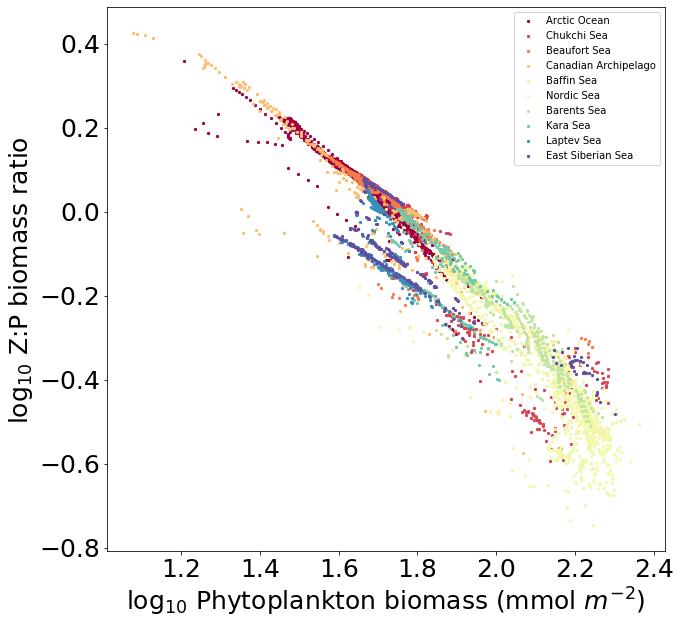

In [24]:
from scipy import stats
#fig, ax = plt.figure(figsize=(10, 10))
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

cmap=matplotlib.cm.get_cmap('Spectral_r', 10)
plt.scatter(y=np.log10(ZP_ao),x=np.log10(P_ao), s=5, alpha=1,color=cmap(9),label='Arctic Ocean')
plt.scatter(y=np.log10(ZP_cs),x=np.log10(P_cs), s=5, alpha=1,color=cmap(8),label='Chukchi Sea')
plt.scatter(y=np.log10(ZP_bs),x=np.log10(P_bs), s=5, alpha=1,color=cmap(7),label='Beaufort Sea')
plt.scatter(y=np.log10(ZP_ca),x=np.log10(P_ca), s=5, alpha=1,color=cmap(6),label='Canadian Archipelago')
plt.scatter(y=np.log10(ZP_bb),x=np.log10(P_bb), s=5, alpha=1,color=cmap(5),label='Baffin Sea')
plt.scatter(y=np.log10(ZP_ns),x=np.log10(P_ns), s=5, alpha=1,color=cmap(4),label='Nordic Sea')
plt.scatter(y=np.log10(ZP_bts),x=np.log10(P_bts), s=5, alpha=1,color=cmap(3),label='Barents Sea')
plt.scatter(y=np.log10(ZP_ks),x=np.log10(P_ks), s=5, alpha=1,color=cmap(2),label='Kara Sea')
plt.scatter(y=np.log10(ZP_ls),x=np.log10(P_ls), s=5, alpha=1,color=cmap(1),label='Laptev Sea')
plt.scatter(y=np.log10(ZP_ess),x=np.log10(P_ess), s=5, alpha=1,color=cmap(0),label='East Siberian Sea')

#ax.axis([1, 3, 1, 3])

pylab.legend(loc='outside')  
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('log$_{10}$ Phytoplankton biomass (mmol $m^{-2}$)', fontsize=25)
plt.ylabel('log$_{10}$ Z:P biomass ratio ',fontsize = 25)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/AO/Z_P_scatter_log_biome'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')